In [33]:
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

# loading precomputed matrices for testing
# (prepared by the camera_calibration.ipynb script)
pickle_in = open("calibration_mat.pickle","rb")
calibration_mat_2 = pickle.load(pickle_in)

In [34]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Four source cordinates
src = np.float32(
    [[254, 700],
     [595, 449],
     [688, 448],
     [1062, 693]
    ])
# Four desired cordinates
dst = np.float32(
    [[254, 700],
     [254, 0],
     [1062, 0],
     [1061, 693]
    ])

Minv = cv2.getPerspectiveTransform(dst, src)
M = cv2.getPerspectiveTransform(src, dst)

def warp(img, src, dst, M=None):   
    img_size = (img.shape[1], img.shape[0])
    if M is None: M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unwarp(img, src, dst, Minv=None):
    img_size = (img.shape[1], img.shape[0])
    if Minv is None: Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped

PREV_leftx_base = None
PREV_rightx_base = None

PREV_left_fit = None
PREV_right_fit = None

sane_left = None
sane_right = None

PREV_leftx = None
PREV_lefty = None
PREV_rightx = None
PREV_righty = None

def sane_lane(left_fitx, right_fitx, left_fit, right_fit, THRESHOLD):
    global sane_left
    global sane_right
    global PREV_left_fit
    global PREV_right_fit
    
    violation = False
    if np.average(np.abs(left_fitx - sane_left)) < THRESHOLD:
        sane_left = left_fitx
        PREV_left_fit = left_fit
    else: 
        violation = True
        #lane deviates too much from the previous frame, keep previous detection   
        left_fit = PREV_left_fit
    if np.average(np.abs(right_fitx - sane_right)) < THRESHOLD:
        sane_right = right_fitx
        PREV_right_fit = right_fit
    else: 
        violation = True
        #lane deviates too much from the previous frame, keep previous detection   
        right_fit = PREV_right_fit
    return violation, left_fit, right_fit

def detect_lane(binary_warped):
    global PREV_leftx_base
    global PREV_rightx_base
    
    global PREV_left_fit
    global PREV_right_fit
    
    global sane_left
    global sane_right

    global PREV_leftx
    global PREV_lefty
    global PREV_rightx
    global PREV_righty

    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    """
    if PREV_leftx_base is None:
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    else:
        leftx_base = PREV_leftx_base
        rightx_base = PREV_rightx_base
    """
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        if window == 0: #update previous base
            PREV_rightx_base = rightx_current
            PREV_leftx_base = leftx_current
                        

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if PREV_leftx is None:
        PREV_leftx = leftx
        PREV_lefty = lefty
        PREV_rightx = rightx
        PREV_righty = righty
        
    
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(np.concatenate((lefty, PREV_lefty)), 
                              np.concatenate((leftx, PREV_leftx)), 2)
    except:
        left_fit = PREV_left_fit
    try:
        #right_fit = np.polyfit(righty, rightx, 2)
        right_fit = np.polyfit(np.concatenate((righty, PREV_righty)), 
                               np.concatenate((rightx, PREV_rightx)), 2)
    except:
        right_fit = PREV_right_fit

    PREV_leftx = leftx
    PREV_lefty = lefty
    PREV_rightx = rightx
    PREV_righty = righty
        
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if sane_left is None:
        sane_left = left_fitx
        sane_right = right_fitx
        PREV_left_fit = left_fit
        PREV_right_fit = right_fit
    else:
        pass
        #violation, left_fit, right_fit = sane_lane(left_fitx, right_fitx, left_fit, right_fit, THRESHOLD=1000)    
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

def get_curvature(left_fit, right_fit, binary_warped):
    lefty = righty = ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    #return left_curverad, right_curverad
    return 'Radius of Curvature: %.1fm '%(max(left_curverad, right_curverad))

def get_position(left_fit, right_fit, binary_warped):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Detect vehicle po sition: assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for.
    mid_lane = (left_fitx[-1] + right_fitx[-1])/2
    deviation_pixels = mid_lane - 1280/2
    deviation_mettres = deviation_pixels * xm_per_pix

    if deviation_mettres > 0 :
        position_str = 'Vehicle is %.2fm left of center'%abs(deviation_mettres)
    else:
        position_str = 'Vehicle is %.2fm right of center'%abs(deviation_mettres)
    return position_str

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a
    
import pdb
def process_image(image):
    global calibration_mat_2
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    undistorted_img = cv2.undistort(image, calibration_mat_2['mtx'], calibration_mat_2['dist'], None, calibration_mat_2['mtx'])
    combined_binary = pipeline(undistorted_img)
    
    imshape = combined_binary.shape
    X = imshape[1]
    Y = imshape[0]
    
    #Define a region of interest
    vertices = np.array([[(0,Y),(0.45*X, 0.55*Y), (0.55*X, 0.55*Y), (X,Y)]], dtype=np.int32)
    selected_img = region_of_interest(combined_binary, vertices)
    
    global M
    binary_warped = warp(selected_img, None, None, M)

    left_fit, right_fit, left_lane_inds, right_lane_inds = detect_lane(binary_warped)

    # Generate x and y values for plotting
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = (left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]).astype(np.int32)
    right_fitx = (right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]).astype(np.int32)
    ploty = ploty.astype(np.int32)
    for i in range(len(ploty)-1):
        cv2.line(out_img,(left_fitx[i], ploty[i]), (left_fitx[i+1], ploty[i+1]) ,(255,255,0),10)
        cv2.line(out_img,(right_fitx[i], ploty[i]), (right_fitx[i+1], ploty[i+1]),(255,255,0),10)
    
    # Create an image to draw the lines on
    warped = binary_warped
    warp_zero = np.zeros((warped.shape[0], warped.shape[1])).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int32([pts]), (0,255, 0))
    
    #cv2.polylines(color_warp,np.int32([pts_left]),True,(255,0,0), thickness=15)
    #cv2.polylines(color_warp,np.int32([pts_right]),True,(0,0,255), thickness=15)
    pts_left = np.int32(pts_left)
    pts_right = np.int32(pts_right)
    
    #pdb.set_trace()
    for i in range(len(pts_left[0])-1):
        cv2.line(color_warp,totuple(pts_left[0][i]),totuple(pts_left[0][i+1]),(255,0,0),25)
        cv2.line(color_warp,totuple(pts_right[0][i]),totuple(pts_right[0][i+1]),(0,0,255),25)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.5, 0)

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (100,100)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(result,'%s %s'%(get_curvature(left_fit, right_fit, binary_warped),
                                get_position(left_fit, right_fit, binary_warped)),
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    #binary_warped = 255*np.stack((binary_warped,)*3, -1)
    #binary_warped = binary_warped.astype(np.int32)
    #pdb.set_trace()
    
    #result = np.hstack((result, color_warp))    
    result = np.hstack((result, out_img))
    
    return result

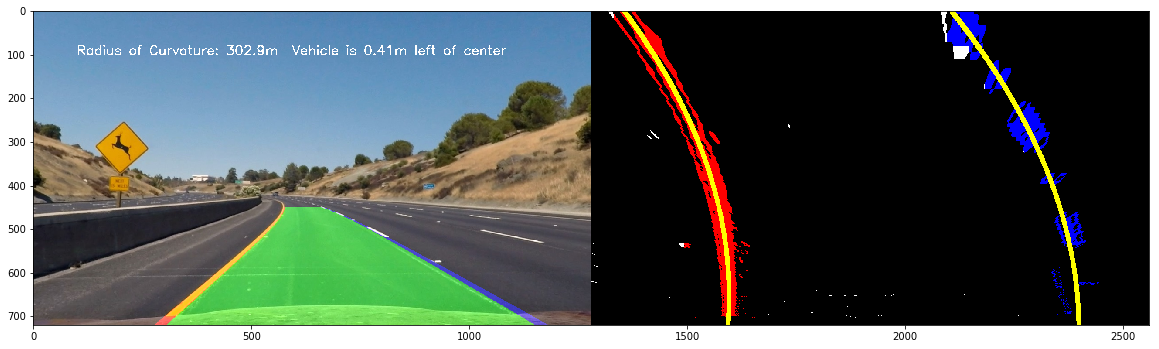

In [35]:
fname = 'test_images/test2.jpg'
img = cv2.imread(fname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = process_image(img)
plt.figure(figsize=(20,20))
plt.imshow(img)


In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './project_video_proccessed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4").subclip(41, 43)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_proccessed.mp4
[MoviePy] Writing video ./project_video_proccessed.mp4



 20%|█▉        | 249/1261 [00:25<01:43,  9.80it/s]


 37%|███▋      | 469/1261 [00:48<01:21,  9.69it/s]


 57%|█████▋    | 722/1261 [01:13<00:54,  9.80it/s]


 77%|███████▋  | 965/1261 [01:38<00:30,  9.80it/s]


 94%|█████████▍| 1186/1261 [02:01<00:07,  9.75it/s]


100%|█████████▉| 1260/1261 [02:09<00:00,  9.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_proccessed.mp4 

CPU times: user 4min, sys: 2min 43s, total: 6min 44s
Wall time: 2min 9s


In [37]:
white_output = './challenge_video_proccessed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./challenge_video_proccessed.mp4
[MoviePy] Writing video ./challenge_video_proccessed.mp4



 61%|██████    | 297/485 [00:28<00:17, 10.53it/s]


100%|██████████| 485/485 [00:45<00:00, 10.55it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_proccessed.mp4 

CPU times: user 1min 24s, sys: 1min 1s, total: 2min 25s
Wall time: 46.5 s


In [38]:
white_output = './harder_challenge_video_proccessed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./harder_challenge_video_proccessed.mp4
[MoviePy] Writing video ./harder_challenge_video_proccessed.mp4



 17%|█▋        | 208/1200 [00:21<01:42,  9.67it/s]


 34%|███▍      | 406/1200 [00:44<01:26,  9.19it/s]


 52%|█████▏    | 624/1200 [01:07<01:02,  9.28it/s]


 67%|██████▋   | 799/1200 [01:27<00:44,  9.09it/s]


 83%|████████▎ | 993/1200 [01:49<00:22,  9.07it/s]


 97%|█████████▋| 1168/1200 [02:10<00:03,  8.98it/s]


100%|█████████▉| 1199/1200 [02:13<00:00,  8.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_video_proccessed.mp4 

CPU times: user 3min 50s, sys: 2min 28s, total: 6min 18s
Wall time: 2min 14s
